Проанализировать данные по выживаемости. Обучить модель предсказания выживет ли человек или нет (ключевая переменная) (различные варианты визуализации можно посмотреть здесь https://www.kaggle.com/competitions/titanic/code?competitionId=3136&sortBy=scoreDescending&language=Python).
Определить наиболее значимые переменные которые влияют на выживаемость. 
Визуализировать дерево решений. 
Написать вывод. 
Не копировать бездумно чужие работы. 


Ответить на вопросы (обоснованно).

1. Как влияет размер семьи  на вероятность виживаемости (одинокие выживают чаще или нет?, люди у которых большая семья (больше 4) выживают чаще или нет).
2. Как влияет пол/возраст/номер палубы. 


Анализ и план работы.
Загружаем тренировочный и тестовый датасеты с данными по Титанику.
Выбираем только колонки с нужной нам информацией.
Cтроим модель дерева решений.
Проверяем влияние перечисленных в задании факторов на выживаемость пассажиров при катастрофе.


In [110]:
%reset
# Importing libraries
import pandas as pd

# Loading datasets
train_table = pd.read_csv('titanic_train.csv')
test_table = pd.read_csv('titanic_test.csv')

# Viewing first strings:
print(train_table.head())

Nothing done.
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN

In [111]:
# check colums types
train_table.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [112]:
# check colums types
test_table.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Здесь:

PassengerId - идентификатор пассажира.

Survived - целевая переменная - выжил ли пассажир.

Pclass - класс проезда

Name - имя пассажира

Sex - пол

Age - возраст

SibSp - кол-во братьев и/или сестер + супруг/супруга

Parch - кол-во детей и/или родителей на борту

Ticket - каки-то сложно интерпретируемые данные билета (точнее, номер-то понятен, а дополнительные цифирки и буковки навряд ли)

Fare - плата за проезд

Cabin - каюта

Embarked - порт отправления

Видим, что в тестовом наборе данных нету ключевой для нас переменной Survived. И зачем нам, тогда, спрашивается, тестовый набор? 
Инференсом мы тут заниматься не собираемся уж точно.
Далее работаем только с тренировчным набором данных.
Также отметим, что из этих данных нам не понадобятся идентификатор и имя пассажира. Также данные по билету (в большинстве случаев это просто номер билета) навряд ли что-то нам дадут.
Данные по каюте потенциально могли бы сообщить что-то полезное, если бы они были сгруппированы по палубам. А в таком виде от номера каюты толку не будет, удаляем.

Размеры датафрейма:

In [113]:
print(train_table.shape)

(891, 12)


In [114]:
train_table = train_table.drop(['PassengerId','Name', 'Ticket', 'Cabin'], axis=1) # axis = 1 for columns
print(train_table.shape)


(891, 8)


In [115]:
print('How many omitted data in each column:')
print(train_table.isna().sum())

How many omitted data in each column:
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64


Видим, что в колонках возраста и места посадки есть пропуски.
По идее, для  обработки с помощью дерева решений это не является показанием к устранению NaN. За что мы этот метод и любим.
Однако конкретно с CatBoost этот финт не прошел. Пришлось заменять на средний возраст.

In [116]:
train_table['Age'] = train_table['Age'].fillna(train_table['Age'].median())
train_table = train_table.dropna(subset=['Embarked'])

In [117]:
print(train_table.isna().sum())

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


В соответствии с заданием рассчитываем размер семьи

In [118]:
# Assigning family size
train_table['FamilySize'] = train_table['SibSp'] + train_table['Parch']  + 1 # 1 for a family with only one person

In [119]:
print(train_table.head())

   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked  FamilySize
0         0       3    male  22.0      1      0   7.2500        S           2
1         1       1  female  38.0      1      0  71.2833        C           2
2         1       3  female  26.0      0      0   7.9250        S           1
3         1       1  female  35.0      1      0  53.1000        S           2
4         0       3    male  35.0      0      0   8.0500        S           1


Заменим пол на цифру

In [120]:
train_table['Sex'] = train_table['Sex'].map({'female': 1, 'male': 0})

Заменим букву порта погрузки на булевские значения

In [121]:
# port of embarkation - to 0/1
train_table = pd.get_dummies(train_table, columns=['Embarked'])

In [122]:
print(train_table.head())

   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  FamilySize  Embarked_C  \
0         0       3    0  22.0      1      0   7.2500           2           0   
1         1       1    1  38.0      1      0  71.2833           2           1   
2         1       3    1  26.0      0      0   7.9250           1           0   
3         1       1    1  35.0      1      0  53.1000           2           0   
4         0       3    0  35.0      0      0   8.0500           1           0   

   Embarked_Q  Embarked_S  
0           0           1  
1           0           0  
2           0           1  
3           0           1  
4           0           1  


Разделяем выборку на таблицу признаков и на колонку целевых переменных

In [123]:
# Splitting into features table and label column
X = train_table.drop(['Survived'], axis=1) # axis = 1 for columns
y = train_table['Survived'] 

Строим дерево решений
(источник вдохновения https://habr.com/ru/articles/711770/)

In [124]:
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier

In [125]:
# Splitting X, y into training and test dataset (with known labels!)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100)
model.fit(X = X_train.values,
          y = y_train)

RandomForestClassifier()

In [126]:
y_pred_train = model.predict(X_train) # prediction on the training data
score0 = accuracy_score(y_train, y_pred_train) * 100

y_pred = model.predict(X_test) # prediction on the test data
score1 = accuracy_score(y_test, y_pred) * 100

print(f'Accuracy on training data: {score0:.2f}')
print(f'Accuracy on test data: {score1:.2f}')

Accuracy on training data: 98.31
Accuracy on test data: 76.97


c:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Другие метрики

In [127]:
# Calculating all the metrics
accuracy = accuracy_score(y_test, y_pred)*100
precision = precision_score(y_test, y_pred)*100
recall = recall_score(y_test, y_pred)*100
f1 = f1_score(y_test, y_pred)*100
roc_auc = roc_auc_score(y_test, y_pred)*100

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
print(f'ROC-AUC: {roc_auc:.2f}')
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 76.97
Precision: 68.92
Recall: 73.91
F1-score: 71.33
ROC-AUC: 76.41
Accuracy: 76.97


Метрики довольно близки друг ко другу.
Визуализируем первое полученное дерево (усредненное дерево по лесу получить невозможно в силу самой задачи. Возможно усреднение результатов, полученных на каждом дереве, но не самих деревьев)

In [139]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
# plot_tree(model.estimators_[0], filled = True, feature_names = train_table.columns.values.tolist(), class_names = ['Survived'])
plot_tree(model.estimators_[0], filled = True)

[Text(0.6559012276785714, 0.9705882352941176, 'x[1] <= 0.5\ngini = 0.475\nsamples = 436\nvalue = [435, 276]'),
 Text(0.42688182043650796, 0.9117647058823529, 'x[6] <= 1.5\ngini = 0.318\nsamples = 288\nvalue = [367, 91]'),
 Text(0.5413915240575397, 0.9411764705882353, 'True  '),
 Text(0.1742001488095238, 0.8529411764705882, 'x[2] <= 77.0\ngini = 0.228\nsamples = 195\nvalue = [271, 41]'),
 Text(0.16626364087301587, 0.7941176470588235, 'x[2] <= 25.5\ngini = 0.224\nsamples = 194\nvalue = [271, 40]'),
 Text(0.051587301587301584, 0.7352941176470589, 'x[9] <= 0.5\ngini = 0.121\nsamples = 46\nvalue = [72.0, 5.0]'),
 Text(0.04365079365079365, 0.6764705882352942, 'gini = 0.0\nsamples = 5\nvalue = [9, 0]'),
 Text(0.05952380952380952, 0.6764705882352942, 'x[2] <= 19.5\ngini = 0.136\nsamples = 41\nvalue = [63, 5]'),
 Text(0.015873015873015872, 0.6176470588235294, 'x[5] <= 7.973\ngini = 0.227\nsamples = 15\nvalue = [20, 3]'),
 Text(0.007936507936507936, 0.5588235294117647, 'gini = 0.0\nsamples = 5\n

<Figure size 2000x1000 with 0 Axes>

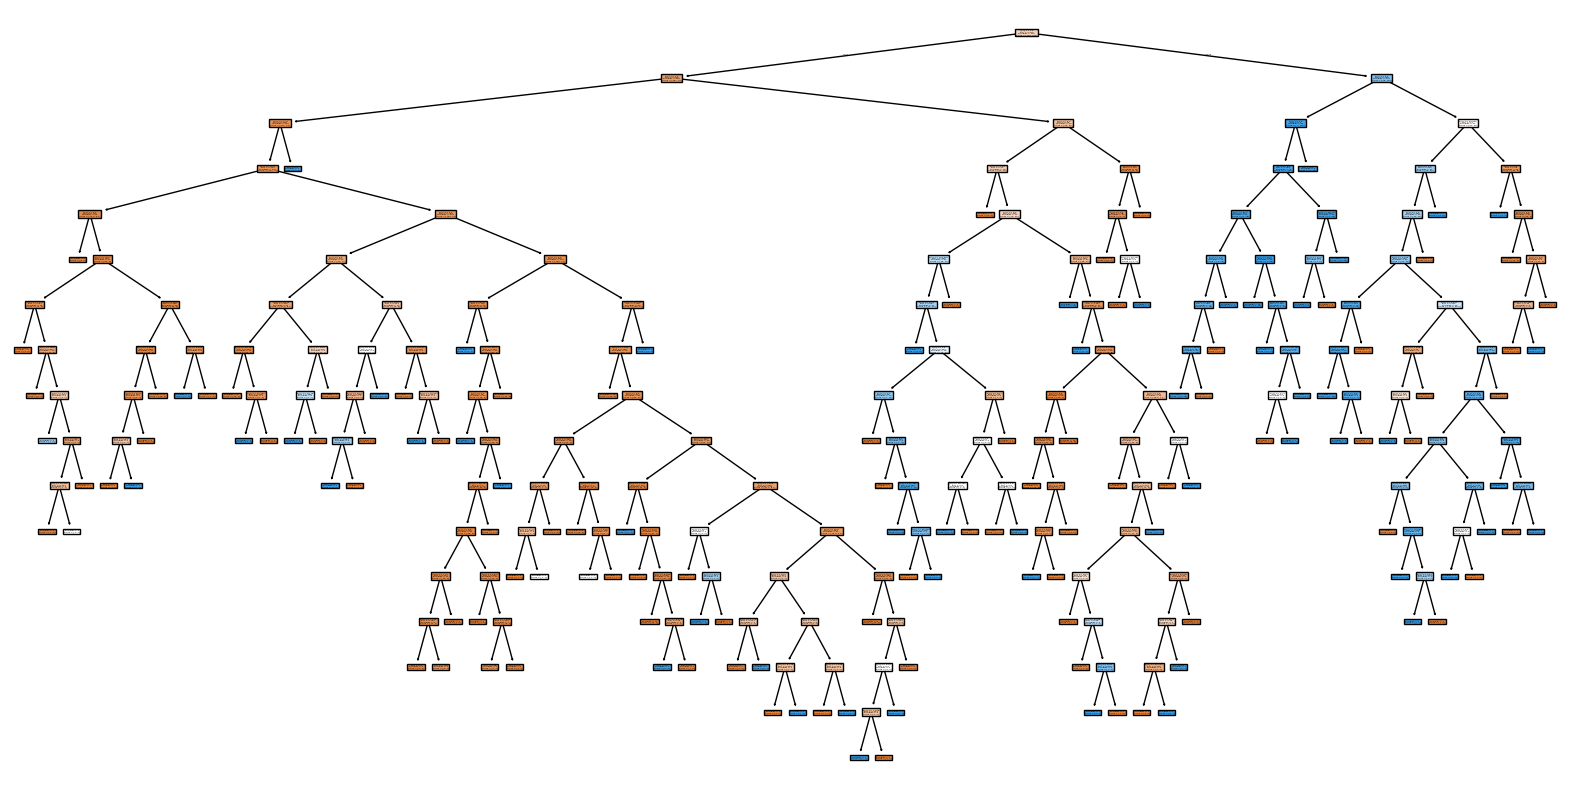

In [140]:
plt.show()

Выводы.
Проделана обработка датасета "Титаник".
Построено дерево решений.
Построена визуализация дерева решений.
Можно сделать несколько выводов на основании полученных результатов.
На вероятность выживания пассажира влияет пол и количество родственников.